# PDP Assignment #3
## Instructions
Train a 3-layer (input, hidden, output) network to classify hand written digits (3 and 5) from the MNIST dataset. Once you set up and trained the network you can choose do either of two things: 

(a) Investigate the performance of the network as a function of the number of hidden units. Make some nice plots. You may also want to investigate other network parameters (e.g. learning rate, simulated annealing). Provide potential explanations for the effects you observe. 

(b) Investigate the hidden layer representations (activation values of hidden units) for input patterns that represent the digits 3 vs. digits 5. This requires reasonable performance of the network. You may also want to investigate how these representations change with learning, e.g., does the average hidden representation for digit 3 become less similar to the average hidden representation for digit 5? Explain what you observe. 

You only have to do either (a) or (b) but you are welcome to complete both exercises

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

## Part 1: The MNIST Dataset
What is the MNIST dataset? From [Wikipedia](https://en.wikipedia.org/wiki/MNIST_database):

> The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits. The MNIST database contains 60,000 training images and 10,000 testing images. The black and white images are normalized to fit into a 28x28 pixel bounding box and anti-aliased.

The challenge of the MNIST dataset is train a neural network (or some other machine learning model) to accurately classify (messy) handwritten numbers. 

### a) Fetch data
To limit computational burden, we will use training and test sets of only 1000 images each. 

In [2]:
from sklearn.datasets import fetch_mldata

## Fetch MNIST dataset.
mnist = fetch_mldata("MNIST original")

## Extract data.
data = mnist['data'] / 255
target = mnist['target']

## Restrict dataset.
n_samples = 1000
ix = np.concatenate([np.where(target==i)[0][:n_samples] for i in np.unique(target)])
data = data[ix]
target = target[ix]

### b) Visualize data
To get an intuition for the dataset we are looking at, we will average across the images of the test/training sets, per digit, and plot the resulting image. It will be clear that when we average across the 2000 images per digit we can cleanly recover the latent digit.

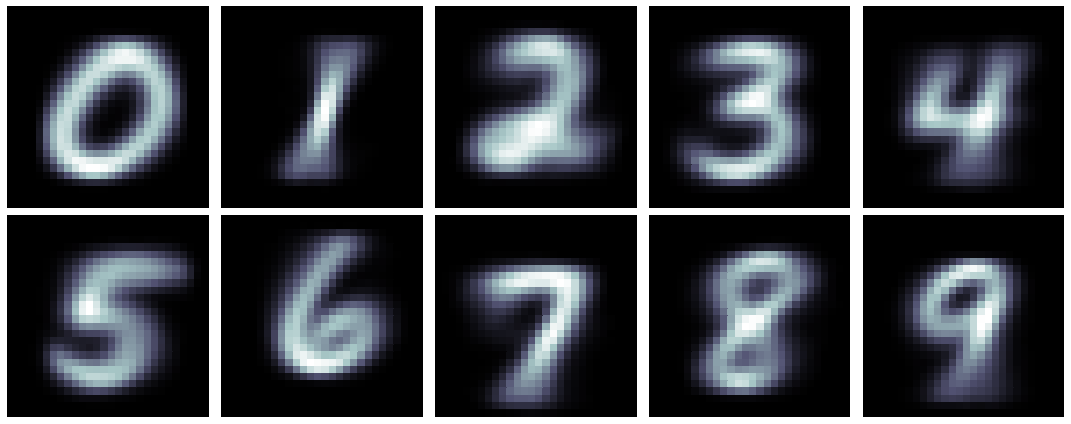

In [3]:
## Initialize canvas.
fig, axes = plt.subplots(2,5,figsize=(15,6))

for i, ax in enumerate(axes.flatten()):
    
    ## Compute mean image.
    avg_img = data[target==i].mean(axis=0)
    
    ## Plot image.
    sns.heatmap(avg_img.reshape(28,28), cmap='bone', square=True, cbar=False, ax=ax)
    ax.set(xticks=[], yticks=[])
    
plt.tight_layout()

## Part 2: Classifying 3s and 5s
To start we will start with the problem of classifying 3s and 5s. How might we go about doing this? Most straightforwardly, we should look at the average 3 and 5 digits, and look for features that distinguish them. The simplest way to do this is subtract one image from the other.

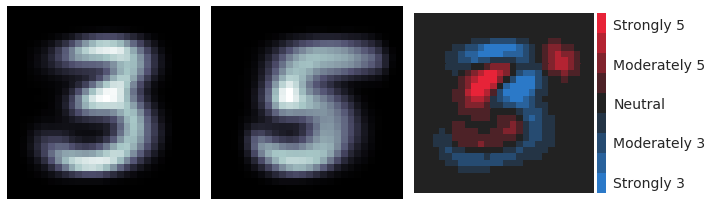

In [4]:
## Reduce to first 1000 3s and 5s.
ix = np.in1d(target, [3,5])
X = data[ix]
Y = target[ix]

## Make average 3/5 image.
average_3_img = data[target==3].mean(axis=0).reshape(28,28)
average_5_img = data[target==5].mean(axis=0).reshape(28,28)

## Plot average images.
fig, axes = plt.subplots(1,3,figsize=(10,10/3))
for ax, img in zip(axes, [average_3_img, average_5_img]):
    sns.heatmap(img, cmap='bone', square=True, cbar=False, ax=ax)
    ax.set(xticks=[], yticks=[])

## Plot subtraction.
cmap = sns.diverging_palette(250, 10, s=90, l=50, n=9, center="dark")
divider = make_axes_locatable(axes[-1])
cax = divider.append_axes("right", size="5%", pad=0.05)

sub_img = average_5_img-average_3_img
sns.heatmap(sub_img, cmap=cmap, vmin=-0.4, vmax=0.4, square=True, ax=axes[-1], cbar_ax=cax)
axes[-1].set(xticks=[], yticks=[])

## Update colorbar.
cbar = axes[-1].collections[0].colorbar
cbar.set_ticks(np.linspace(-0.35,0.35,5))
cbar.ax.set_yticklabels(['Strongly 3', 'Moderately 3', 'Neutral', 'Moderately 5', 'Strongly 5'], fontsize=14);

plt.tight_layout()

As can plainly be observed above, there are features that are most strongly representative of 5s (red), most strongly representative of 3s (blue), and representative of neither (black). 

Insofar that simple subtraction can reasonably yield features unique to either digit, this suggests that we may be able to solve the problem with tools simpler than a neural network. We demonstrate this below with regularized logistic regression.

### a) Logistic Regression

In the model below, we train a logistic regression classifier to discriminate between 3s and 5s. Specifically, the classifier fits a weight to each feature (square) of the 28x28 grid. Positive weights will denote a feature predictive of 5s and negative weights will denote a feature predictive of 3s. The weights are fitted independently of each other. 

#### Model fitting and performance
Based on the subtraction image above, we might assume that not all of the features will be very predictive of 3s vs. 5s. (Indeed much of the subtraction image above is colored black, suggesting that those features are not informative.) As such, we will set a regularization term ($\alpha$) on our logistic regression classifier that will enforce sparsity on our model (i.e. set many of the weights to zero). We do not know *a priori* what the right level of sparsity is, so we train our model with several levels of sparsity and see which level performs best.

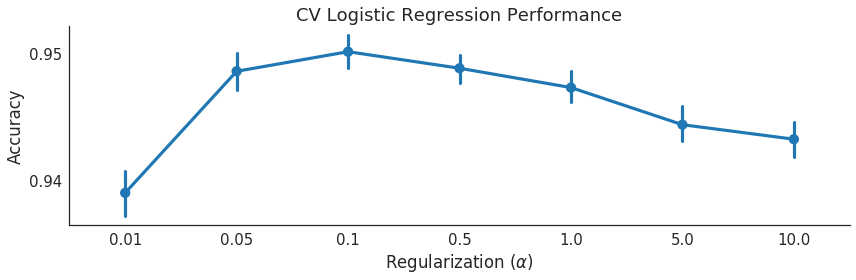

In [5]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedShuffleSplit

## Define training parameters.
Cs = np.array([0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.])
train_size = 0.5
test_size = 0.5
n_splits = 50

## Initialize scikit-learn objects.
cv = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, 
                             train_size=train_size, random_state=0)
lrcv = LogisticRegressionCV(Cs=Cs, cv=cv, penalty='l2', random_state=0)

## Fit cross-validated model.
fit = lrcv.fit(X,Y)
scores = DataFrame(fit.scores_[5], columns=fit.Cs_).melt()

## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,4))
sns.pointplot('variable','value',data=scores, ax=ax)
ax.set(xlabel=r'Regularization ($\alpha$)', ylabel='Accuracy', yticks=[0.94,0.95],
       title='CV Logistic Regression Performance')
sns.despine()
plt.tight_layout()

As can be observed above, out-of-sample classification accuracy is highest with a moderate level of regularization ($\alpha = 0.1$). Impressively, this classifier is achieves approximately 95% classification accuracy. In other words, with simple logistic regression on each feature (pixel) can successfully discriminate between 3s and 5s for 19/20 cases! We visualize the weights of this model below. 

#### Predictive weights

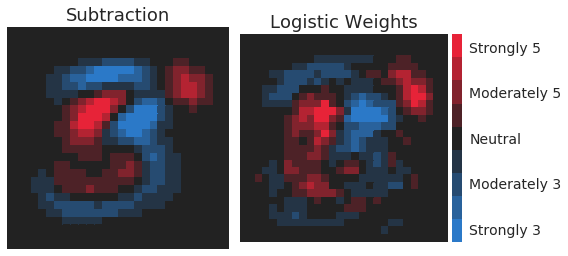

In [6]:
## Extract weights.
w = np.median(fit.coefs_paths_[5][:,Cs==0.1,:-1], axis=0)
w = w.reshape(28,28)

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(8,4))

## Plot subtraction.
sns.heatmap(sub_img, cmap=cmap, vmin=-0.4, vmax=0.4, square=True, cbar=False, ax=axes[0])
axes[0].set(xticks=[], yticks=[], title='Subtraction')

## Plot logistic weights.
divider = make_axes_locatable(axes[-1])
cax = divider.append_axes("right", size="5%", pad=0.05)

sns.heatmap(w, vmin=-0.4, vmax=0.4, square=True, cmap=cmap, ax=axes[-1], cbar_ax=cax)
axes[-1].set(xticks=[], yticks=[], title='Logistic Weights')

## Update colorbar.
cbar = axes[-1].collections[0].colorbar
cbar.set_ticks(np.linspace(-0.35,0.35,5))
cbar.ax.set_yticklabels(['Strongly 3', 'Moderately 3', 'Neutral', 'Moderately 5', 'Strongly 5'], fontsize=14);
plt.tight_layout()

As expected, the weights of the logistic regression classifier strongly resemble the subtraction image. In other words, the logistic regression classifier is simply finding those features that are unique to 3s and 5s, respectively, to classify the two digits.  

We can quantify the similar between the subtraction image and the weights image by computing their angle using cosine similarity. By definition:

> Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. The cosine of 0 degrees is 1, and it is less than 1 for any other angle in the interval $[0,2\pi)$. It is thus a judgment of orientation and not magnitude: two vectors with the same orientation have a cosine similarity of 1, two vectors at 90 degrees have a similarity of 0, and two vectors diametrically opposed have a similarity of -1, independent of their magnitude. 

Given two vectors, cosine similarity is defined as:

$$ cos(\theta) = \frac{A \cdot B}{\lVert A \rVert \lVert B \rVert} =
    \frac{\sum_{i=1}^{n} A_i B_i}{\sqrt{\sum_{i=1}^n A_i^2}\sqrt{\sum_{i=1}^n B_i^2}}$$

In [7]:
from scipy.spatial.distance import cosine
print('Cosine similarity = %0.3f' %(1 - cosine(sub_img.flatten(), w.flatten())))

Cosine similarity = 0.765


### b) Neural Network
Given the results above, we should expect the weights of a neural network classifier to come to represent 

#### Model fitting and performance

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

## Split data.
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.5, test_size=0.5, 
                                                    stratify=Y, random_state=0)

## Initialize neural network.
nn = MLPClassifier((1), activation='logistic', solver='sgd', learning_rate='constant', 
                   alpha=1, max_iter=1000, learning_rate_init=0.1, momentum=0, random_state=0)

## Train.
fit = nn.fit(X_train, y_train)

## Compute out-of-sample accuracy.
print('Out-of-sample prediction accuracy = %s' %fit.score(X_test, y_test))

Out-of-sample prediction accuracy = 0.946


#### Predictive weights

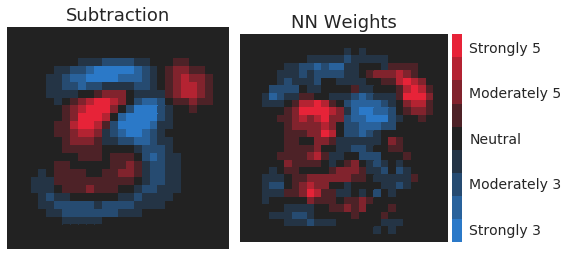

In [9]:
## Extract weights.
w = fit.coefs_[0].reshape(28,28)
w *= -1

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(8,4))

## Plot subtraction.
sns.heatmap(sub_img, cmap=cmap, vmin=-0.4, vmax=0.4, square=True, cbar=False, ax=axes[0])
axes[0].set(xticks=[], yticks=[], title='Subtraction')

## Plot neural network weights.
divider = make_axes_locatable(axes[-1])
cax = divider.append_axes("right", size="5%", pad=0.05)

sns.heatmap(w, vmin=-0.4, vmax=0.4, square=True, cmap=cmap, ax=axes[-1], cbar_ax=cax)
axes[-1].set(xticks=[], yticks=[], title='NN Weights')

## Update colorbar.
cbar = axes[-1].collections[0].colorbar
cbar.set_ticks(np.linspace(-0.35,0.35,5))
cbar.ax.set_yticklabels(['Strongly 3', 'Moderately 3', 'Neutral', 'Moderately 5', 'Strongly 5'], fontsize=14);
plt.tight_layout()

In [10]:
from scipy.spatial.distance import cosine
print('Cosine similarity = %0.3f' %(1 - cosine(sub_img.flatten(), w.flatten())))

Cosine similarity = 0.701


## Part 3: Classifying all digits

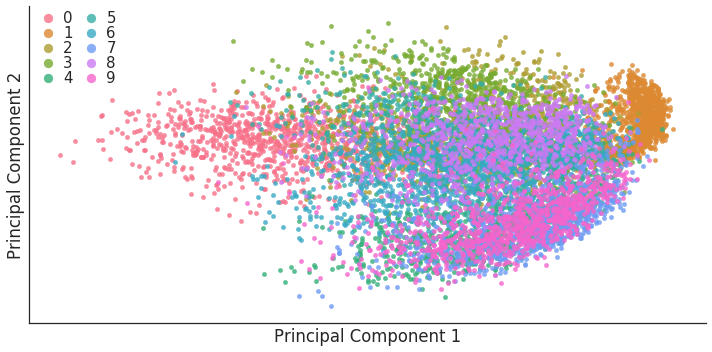

In [11]:
## Compute principal components.
U, S, Vt = np.linalg.svd( np.cov(data.T) )

## De-mean data.
X0 = np.apply_along_axis(lambda arr: arr - arr.mean(), 0, data)

## Project onto first two principal components.
X0_proj = X0 @ U[:,:2]

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(10,5))

## Iteratively plot.
for i, color in enumerate(sns.husl_palette(n_colors=10).as_hex()):
    
    ax.scatter(*X0_proj[target==i].T, s=20, color=color, label=i, alpha=0.8)
    
## Add info.
ax.set(xticks=[], xlabel='Principal Component 1', yticks=[], ylabel='Principal Component 2')
ax.legend(loc=2, ncol=2, markerscale=2, borderpad=-0.25, labelspacing=0, 
          columnspacing=0.25, handletextpad=0)

sns.despine()
plt.tight_layout()

Though an eyesore to look at, what we find is that the digits do not seem to cleanly separate into 10 distinct categories. Though certain digits seem to be unique (0s and 1s, for example, simple to occupy largely non-overlapping positions in 2d principal component space), most share considerable overlap. 

This suggests that simple linear classification will fail.

### a) Limitations of Logistic Regression

In [12]:
## Split data.
X_train, X_test, y_train, y_test = train_test_split(data, target, train_size=0.5, test_size=0.5, 
                                                    stratify=target, random_state=0)

## Initialize neural network.
nn = MLPClassifier((1), activation='logistic', solver='sgd', learning_rate='constant', 
                   alpha=1, max_iter=1000, learning_rate_init=0.01, momentum=0, random_state=0)

## Train.
fit = nn.fit(X_train, y_train)

## Compute out-of-sample accuracy.
print('Out-of-sample prediction accuracy = %s' %fit.score(X_test, y_test))

Out-of-sample prediction accuracy = 0.2132


### b) Multi-unit Neural Network Performance

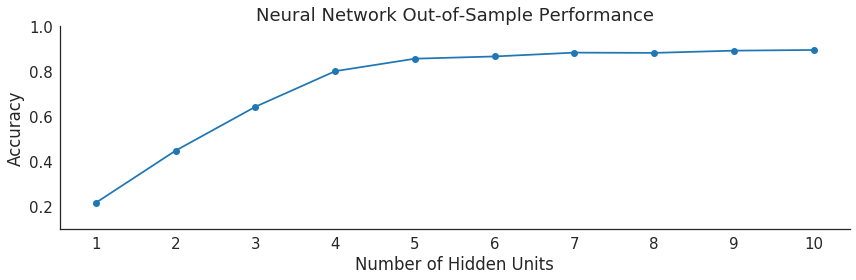

In [13]:
## Define sizes.
sizes = np.arange(10) + 1

## Main loop.
scores = np.zeros_like(sizes, dtype=float)

for i, n in enumerate(sizes):

    ## Initialize neural network.
    nn = MLPClassifier((n), activation='logistic', solver='sgd', learning_rate='constant', 
                       alpha=1, max_iter=1000, learning_rate_init=0.1, momentum=0, random_state=0)

    ## Train.
    fit = nn.fit(X_train, y_train)
    
    ## Compute out-of-sample accuracy.
    scores[i] = fit.score(X_test, y_test)

## Plot.
fig, ax = plt.subplots(1,1,figsize=(12,4))

ax.plot(sizes, scores, marker='o')
ax.set(xticks=sizes, xlabel='Number of Hidden Units', ylim=(0.1,1), ylabel='Accuracy',
       title='Neural Network Out-of-Sample Performance')

sns.despine()
plt.tight_layout()

### c) Sparse Representations

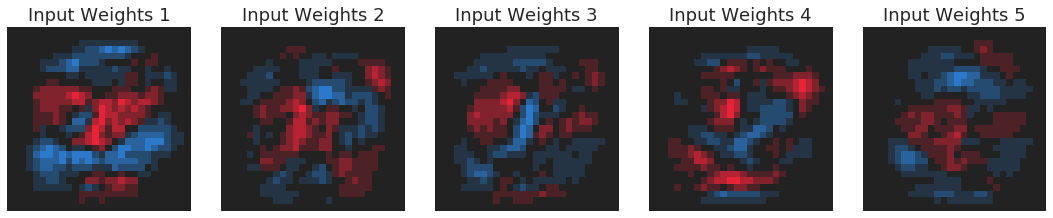

In [14]:
## Initialize neural network.
nn = MLPClassifier((5), activation='logistic', solver='sgd', learning_rate='constant', 
                   alpha=1, max_iter=1000, learning_rate_init=0.1, momentum=0, random_state=0)

## Train.
fit = nn.fit(X_train, y_train)

## Extract weights.
input_weights = fit.coefs_[0].T

## Initialize canvas.
fig, axes = plt.subplots(1,5,figsize=(15,3))

for ax, w, i in zip(axes.flatten(), input_weights, np.arange(5)+1):
        
    ## Plot image.
    sns.heatmap(w.reshape(28,28), cmap=cmap, center=0, square=True, cbar=False, ax=ax)
    ax.set(xticks=[], yticks=[], title='Input Weights %s' %i)
    
plt.tight_layout()

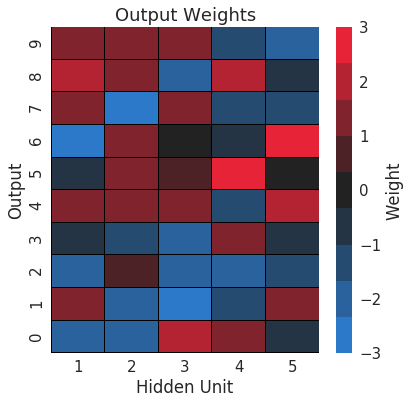

In [15]:
## Extract output weights.
output_weights = fit.coefs_[1].T

## Plot.
fig, ax = plt.subplots(1,1,figsize=(6,6))

sns.heatmap(output_weights, cmap=cmap, vmin=-3, vmax=3, linewidths=0.05, linecolor='k',
            xticklabels=np.arange(5)+1, cbar_kws=dict(label='Weight'), ax=ax)
ax.set(xlabel='Hidden Unit', ylabel='Output', title='Output Weights')
ax.invert_yaxis()

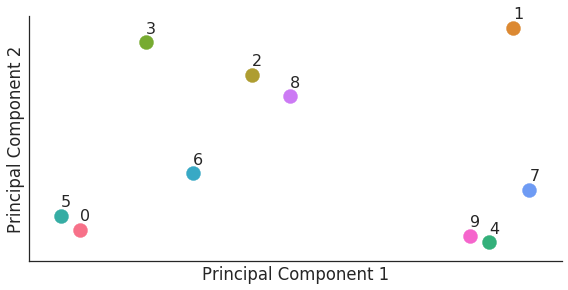

In [16]:
## Project output weights.
U, S, V = np.linalg.svd( np.cov(output_weights.T) )
w0_proj = np.apply_along_axis(lambda arr: arr - arr.mean(), 0, output_weights) @ U[:,:2]

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Iteratively plot.
for i, color in enumerate(sns.husl_palette(n_colors=10).as_hex()):
    
    ax.scatter(*w0_proj[i].T, s=200, color=color)
    ax.text(*w0_proj[i].T + [0,0.2], i, fontsize=16)
    
## Add info.
ax.set(xticks=[], xlabel='Principal Component 1', yticks=[], ylabel='Principal Component 2')


sns.despine()
plt.tight_layout()

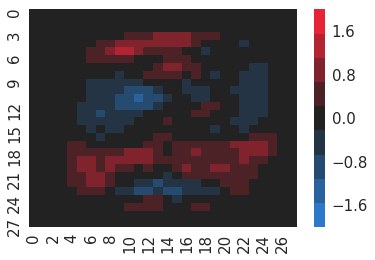

In [17]:
sns.heatmap((output_weights[2] @ input_weights).reshape(28,28), cmap=cmap, vmin=-2, vmax=2)